# 2025 Spring ORF307 Final Project Solutions

Instructor: B. Stellato

AIs: Yanjun Liu, Qishuo Yin, Chenyu Yu, and Kaiwen Zhang

___

## Instructions
**Exam files:** the exam files are available to download at [THIS LINK.](https://www.dropbox.com/scl/fo/b6an98pypucpvdhb81osz/AHSPIHMuLOtnttr-CDG6ZZY?rlkey=6wph0csyr9gldp2lo7akkx4ln&st=ckxp1xua&dl=0)

**Date and time:** From May 8, 2025 at 00:01 am to May 11, 2025 at 7:00pm.

- Total time after download: 24 hours. No late submissions allowed. Note that the deadline is either 24 hours after download, or May 11, 2025 at 7:00pm, **whichever comes first**.

## Exam Rules
- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you cannot use internet to search for answers.
- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.
- You cannot communicate with anyone during the exam.
- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.
- The exam is to be submitted electronically on Gradescope before 7:00pm on the final day.

# Final Exam

## Introduction 

For this final project, you will work with the Fashion MNIST dataset including thousands of images of clothes, which we have provided in CSV format. 

You will work with a pre-processed version of this dataset where each label is +1 if the image is a shirt and -1 otherwise.

To load the dataset, ensure the following files are in a folder called `data/` in your working directory: `X_train.csv`, `y_train.csv`, `X_test.csv`, `y_test.csv`. Then run the following code to import the packages and load the data

In [1]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv(f"data/X_train.csv").values
y_train = pd.read_csv(f"data/y_train.csv").values.ravel()
X_test = pd.read_csv(f"data/X_test.csv").values
y_test = pd.read_csv(f"data/y_test.csv").values.ravel()

n_train, m = X_train.shape
n_test, m = X_test.shape

print("-" * 50)
print("Fashion MNIST dataset")
print("-" * 50)
print(f"Number of features: {m}  ({int(np.sqrt(m))} x {int(np.sqrt(m))} pixels)")
print(f"Training set:")
print(f"  • Samples: {n_train}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Test set:")
print(f"  • Samples: {n_test}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")

--------------------------------------------------
Fashion MNIST dataset
--------------------------------------------------
Number of features: 784  (28 x 28 pixels)
Training set:
  • Samples: 5000
  • Value range: [0.00, 255.00]
Test set:
  • Samples: 1000
  • Value range: [0.00, 255.00]


Now, let's visualize a couple of images

In [11]:
def visualize_images(*images):
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(14,6))
    if n_images == 1:
        axes = [axes]   
    for i, (ax, img) in enumerate(zip(axes, images)):
        img_reshaped = img.reshape(28, 28)
        im = ax.imshow(img_reshaped, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

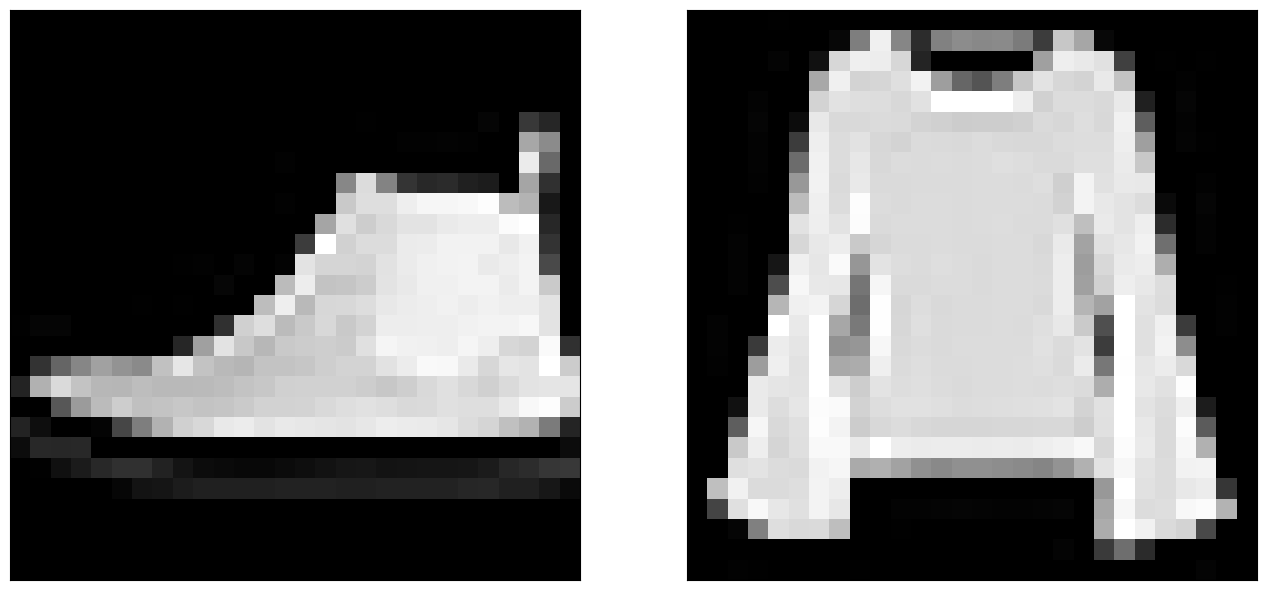

In [12]:
example_boot = X_train[3]
example_shirt = X_train[0]
visualize_images(example_boot, example_shirt)

# 1. (35 points) Build a Support Vector Machine to correctly classify shirts

1. (5 points) Formulate a Support Vector Machine problem to find a hyperplane $(a, b)$ where $a \in \mathbf{R}^m$ and $b \in \mathbf{R}$ to classify shirts. Given sample $x^{(i)}$, your hyperplane should be $a^Tx^{(i)} + b > 0$ if label $y^{(i)} = 1$ (shirt) or $a^Tx^{(i)} + b < 0$ if label $y^{(i)} = -1$ (not a shirt). You should include a second term in the objective, weighted by parameters $\lambda > 0$ to regularize the $\ell_1$-norm of $a$.

    Note: Remember to normalize the misclassification error by the total number of training samples.

\[
\begin{array}{ll@{}ll}
\min\limits_{a, b, \xi} & \displaystyle \frac{1}{N} \sum_{i=1}^{N} \xi^{(i)} + \lambda \|a\|_1 & & \\
\text{s.t.} & y^{(i)}(a^T x^{(i)} + b) \geq 1 - \xi^{(i)}, & \quad \forall i = 1, \dots, N, & \\
            & \xi^{(i)} \geq 0, & \quad \forall i = 1, \dots, N. &
\end{array}
\]

In [24]:
class SVM:
    def __init__(self, lambda_val):
        """
        Initialize SVM with L1 regularization parameter.

        Parameters:
        -----------
        lambda_val : float
            Regularization strength (must be >= 0).
        """
        if lambda_val < 0:
            raise ValueError("lambda_val must be non-negative.")
        self.lambda_val = lambda_val
        self.a = None
        self.b = None

    def fit(self, X, y, solver=cp.CLARABEL, verbose=False):
        """
        Fit the SVM model to the training data using convex optimization.

        Parameters:
        -----------
        X : np.ndarray, shape (n_samples, n_features)
            Training feature matrix.
        y : np.ndarray, shape (n_samples,)
            Training labels (±1).
        solver : cvxpy solver, optional
            Solver to use (default: CLARABEL).
        verbose : bool, optional
            Whether to print solver progress (default: False).

        Returns:
        --------
        a : np.ndarray
            Learned weight vector.
        b : float
            Learned bias term.
        """
        n_samples = X.shape[0]
        a = cp.Variable(X.shape[1])
        b = cp.Variable()
        
        # Hinge loss (average per sample) + L1 regularization
        hinge_loss = cp.sum(cp.pos(1 - cp.multiply(y, X @ a + b))) / n_samples
        objective = cp.Minimize(hinge_loss + self.lambda_val * cp.norm(a, 1))
        
        # Solve the problem
        problem = cp.Problem(objective)
        problem.solve(solver=solver, verbose=verbose)
        
        self.a = a.value
        self.b = b.value
        
        return self.a, self.b

    def predict(self, X):
        """
        Predict labels for input data.

        Parameters:
        -----------
        X : np.ndarray, shape (n_samples, n_features)
            Input feature matrix.

        Returns:
        --------
        y_pred : np.ndarray, shape (n_samples,)
            Predicted labels (±1).
        """
        if self.a is None or self.b is None:
            raise RuntimeError("Model not trained. Call fit() first.")
        return np.sign(X @ self.a + self.b)


2. (7 points) Run a cross-validation procedure: solve the problem using CVXPY and CLARABEL solver for $\lambda = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05)$ and pick the model that has the lowest test error.

    Note, these problems are quite large so it may take a few seconds to solve them. (you may use the argument `verbose=True` to print out the solver progress).

    Here is a utility function to check the test error. For example, you can use it as `error(X_test, y_test, a, b)`

In [25]:
def error(X, y, a, b):
    y_pred = np.sign(X @ a + b)
    return np.mean(y_pred != y)

In [23]:
lambda_vals = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

svms = {}
test_errors = {}

for lambda_val in lambda_vals:
    svm = SVM(lambda_val)
    svm.fit(X_train, y_train)
    svms[lambda_val] = svm
    test_errors[lambda_val] = error(X_test, y_test, svm.a, svm.b)

errors = pd.Series(test_errors)
errors


0.0001    0.192
0.0005    0.197
0.0010    0.197
0.0050    0.189
0.0100    0.180
0.0500    0.172
dtype: float64

3. (7 points) Write the training problem as a linear program in inequality form (get rid of all norms in the formulation)

4. (7 points) Write the dual problem and call the dual variables corresponding to the misclassified points as $z \in \mathbf{R}^{\rm n\_train}$.

5. (7 points) Identify which points are misclassified using the dual variables $z$. Visualize the images corresponding to the 5 largest dual variables. How do they compare to a shirt image below?

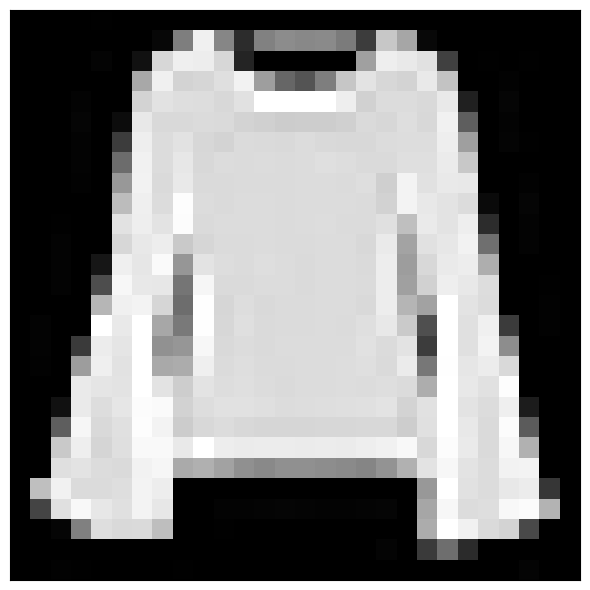

In [26]:
example_shirt = 0
visualize_images(X_train[example_shirt])

# (25 points) computing adversarial examples

We now would like to verify the robustness of our classifier by looking at adversarial examples. To do so, we will consider all images close to a *representative image* and see if appropriate pixel perturbations could confuse our classifier.

1. (10 points) Formulate the problem of finding the closest image, in terms of the $\ell_1$-norm, to the shirt one at index `example_shirt = 0`, that gets misclassified.

    Note: images have pixel intensities between 0 and 255.

1. $$ \begin{array}{ll@{}l}
\min\limits_{x} & \|x - x_{\text{orig}}\|_1 = \sum_{j=1}^m |x_j - x_{\text{example},j}| & \\
\text{s.t.} & a^T x + b \leq 0 & \text{(Misclassification constraint)} \\
& 0 \leq x_j \leq 255, & \forall j = 1, \dots, m \text{ (Pixel bounds)}
\end{array} $$


2. (5 points) Formulate the problem as a linear program in inequality form without including any norm.
$$ \begin{array}{ll}
\text{maximize} & \sum_i t_i \\
\text{subject to } & a^Tx + b \leq 0 \\
& t_j \geq x_j - x_{example, j} \quad \forall j \\
& t_j \geq x_{example, j} - x_j \quad \forall j \\
& 0 \leq x_j \leq 255 \forall j \\
& t_j \geq 0 forall j
\end{array} $$

3. (10 points) Solve problem compare the resulting image with the example shirt above. How many pixels are modified? What is the $\ell_1$-norm distance between the images? Plot the images side by side using the `visualize_images` function above and describe what's different.

In [29]:
def find_misclassified_lp(x_example, a, b):
    """
    Finds the closest misclassified image to x_example via LP formulation.
    
    Parameters:
        x_example : np.ndarray (original image, shape [m,])
        a         : np.ndarray (SVM weights, shape [m,])
        b         : float      (SVM bias)
        epsilon   : float      (small positive value for strict inequality)
    
    Returns:
        x_adv : np.ndarray (adversarial image)
    """
    m = len(x_example)
    x = cp.Variable(m)
    t = cp.Variable(m)  # Auxiliary variables for |x_j - x_example,j|
    
    objective = cp.Minimize(cp.sum(t))
    constraints = [
        a.T @ x + b <= 0,           # Misclassification
        x - x_example <= t,                 # t_j ≥ x_j - x_example,j
        x_example - x <= t,                 # t_j ≥ x_example,j - x_j
        0 <= x, x <= 255,                   # Pixel bounds
        t >= 0                              # t_j ≥ 0
    ]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL)
    
    if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        raise ValueError(f"Optimization failed with status: {problem.status}")
    
    return x.value

In [35]:
best_lambda = np.argmin() 
a = svms[best_lambda].a
b = svms[best_lambda].b
adv_example = find_misclassified_lp(X_train[example_shirt], a, b)

visualize_images(X_train[example_shirt], adv_example)


KeyError: np.int64(5)

In [34]:
np.sum(adv_example != X_train[example_shirt])

np.int64(784)